In [1]:
import pandas as pd
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gzip 
import math
import itertools
from time import time
from tqdm import tqdm
import tqdm.notebook as tq
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os
import vec_tools
import word_tools
import statistics
from nltk.corpus import stopwords
import random
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from matplotlib import cm

# Create/load domains

In [2]:
lst_dir =  "G:/My Drive/KU/Thesis/data/domains/" 
domain_dic = {}

garg_lists = ["occupations1950.txt", "adjectives_appearance.txt",  'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt', 'adjectives_otherization.txt', 'adjectives_princeton.txt',
 'adjectives_sensitive.txt', 'adjectives_williamsbest.csv', 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt', 'occupations1950_professional.txt']

for dic in garg_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/garg/{dic}", encoding="utf-8").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]

wiki_lists = ['music_genres','lit_genres','us_cities','uk_cities',
               'countries','hobbies','subcultures'] #sports
for lst in wiki_lists:
    domain_dic[lst] = word_tools.load_list(f"{lst_dir}/wiki/{lst}_wiki.txt")
    
manual_lists = [ 'virtues.txt', 'vices.txt', 'genres.txt', 'emotions.txt', 'housing.txt',
 'clothing.txt', 'white_trash.txt', 'old_rich.txt', 'new_rich.txt', 'u.txt', 'new_u.txt', 'non_u.txt',
 'refined.txt', 'sports.txt', 'unrefined.txt', 'art_movs.txt', 'Subcultures.txt', 'places-of-entertainment.txt']
for dic in manual_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/domains/{dic}").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]
domain_dic.keys()

domain_dic["goc_genres"] = ["hiphop", "rap", "bluegrass", "opera", "jazz", "techno", "punk"]

#"goc_genres", "art_movs", "hobbies", "genres", "emerging_traditional_genres", "housing"

In [3]:
groups =['Iso_occupations.xlsx','standard_occupations_uk_incomplete.xlsx','occupations_1950_categorised.xlsx','vices_virtues.xlsx','u_non_u.xlsx','old_rich_new_rich.xlsx','emerging_traditional_genres.xlsx']
os.chdir("G:/My Drive/KU/Thesis/data/domains/dicts/")
os.listdir()
for group in groups: 
    domain_dic[group[:-5]] = vec_tools.load_domain_dic(f"G:/My Drive/KU/Thesis/data/domains/dicts/{group}")
   

In [4]:
domain_dic["all_cult"] = {"Places of Entertainment":domain_dic["places-of-entertainment"], "Clothing":domain_dic["clothing"], "Sport":domain_dic["sports"], "Leisure": ['gallery', 'bingo', 'sport', 'theatre', 'opera', 'dance', 'magazine', 'diy', 'pub', 'classical', 'shopping', 'restaurant', 'tv', 'television', 'reading', 'gig', 'sports', 'art', 'art', 'autosport', 'camping', 'gardening', 'dancing', 'dance', 'concert', 'gig', 'hunting', 'fishing', 'sports', 'sport', 'reading'],"Music":domain_dic["goc_genres"]}
#domain_dic["all_cult"] = {"Sport":domain_dic["sports"]}
domain_dic["valid_doms"] = {"Activities": ['gallery', 'bingo', 'sport', 'theatre', 'opera', 'dance', 'magazine', 'diy', 'pub', 'classical', 'shopping', 'restaurant', 'tv', 'television', 'reading', 'gig', 'sports', 'art', 'art', 'autosport', 'camping', 'gardening', 'dancing', 'dance', 'concert', 'gig', 'hunting', 'fishing', 'sports', 'sport', 'reading', 'pop'],
"Music": ['reggae', 'jazz', 'pop', 'folk', 'classical', 'big-band', 'bluegrass', 'country', 'blues', 'musicals', 'classical', 'folk', 'gospel', 'jazz', 'salsa', 'easy-listening', 'new-age', 'opera', 'rap', 'reggae',  'oldies', 'heavy-metal']}

# Almighty iterator

In [5]:
coll = "histwords_engall"#"gb_12_18_02"#
#input_dir = f"D:/google_ngrams/vectors/{coll}"
dims = ["affluence", "cultivation", "status", "gender", "race", "morality", "education"]
histwords_iter = vec_tools.AllDecsIterator(coll, dims, kv=True, test=False)
histwords_iter.iterate()

coll = "gb_12_18_02"
#gb_12_iter = vec_tools.AllDecsIterator(coll, dims, kv=False, test=False)
#gb_12_iter.iterate()
#dists = iterator.stability_through_time()
#iterator.avg_distance(n=50)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:161: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
G:\My Drive\KU\Thesis\vec_tools.py:152: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot)


# Drift in cultural domains

In [11]:
self = histwords_iter
wv = histwords_iter.wvs["1900"]
l = 0
w = True


q = 0
top_words = pd.read_csv("G:/My Drive/KU/Thesis/data/unigram_freq.csv")
top_words = top_words["word"].to_list()[:10000]
input_words = top_words
#input_words = domain_dic["all_cult"]["Clothing"]



for dec, wv in self.wvs.items():
    ind2key = wv.index_to_key
    norm = self.norm_matrix[dec]
    if q == 0:
        words = []
        for word in input_words:
            try:
                vec = wv[word]
            except:
                continue
            if np.mean(vec) == 0:
                w = False
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                words.append(word)
            w = True
        words = set(words)
        q += 1
    elif q == "PREVIOUS VERSION":
        words = []
        for i, vec in enumerate(norm):
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                l += 1
                words.append(ind2key[i])
            w = True
        words = set(words)
        q = 1
    else: 
        words2 = []
        for i, vec in enumerate(norm):
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                words2.append(ind2key[i])
            w = True
        words2 = set(words2)
        words = words.intersection(words2)
words = list(words)

In [22]:
domain_dic["all_cult"]["Top 10,000"] =words
from nltk.corpus import stopwords
domain_dic["all_cult"]["Function words"] = list(stopwords.words('english'))


In [23]:
df_s = {}
df = {}
for dom, lst in domain_dic["all_cult"].items():
    if dom == "Music":
        continue
   # print("\n", dom, "\n")
    vec_tools.get_projection_corrs(histwords_iter, lst, p_val=True)
  #  vec_tools.plot_projection_corrs(histwords_iter, n=8, k=2, save = dom)
    df[dom] = {}
    df_s[dom] = {}
    for i,dim in enumerate(histwords_iter.dims):
        tup = histwords_iter.proj_corrs[dim]["1900"]["1990"]
        df[dom][dim] = tup[0]
        cor = str(round(tup[0],3))
        if tup[1] < 0.05:
            cor = cor + "**"
        
        df_s[dom][dim] = cor
        #print(dim, histwords_iter.proj_corrs[dim]["1900"]["1990"])
#plot_projection_corrs(self, n=8)
df = pd.DataFrame(df)
df.index = [dim.title() for dim in df.index]
df_s = pd.DataFrame(df_s)
df_s.index = [dim.title() for dim in df_s.index]

In [16]:
print(df_s.to_latex())

\begin{tabular}{llllll}
\toprule
{} & Places of Entertainment & Clothing &    Sport &  Leisure & Top 10,000 \\
\midrule
Affluence   &                  -0.064 &  0.463** &  0.608** &  0.604** &    0.501** \\
Cultivation &                   0.369 &   0.51** &  0.573** &    0.396 &    0.463** \\
Status      &                 0.688** &    0.369 &    0.6** &    0.376 &    0.674** \\
Gender      &                   0.321 &  0.539** &  0.674** &  0.575** &    0.348** \\
Race        &                   0.275 &    0.233 &   -0.515 &   -0.028 &    0.104** \\
Morality    &                 0.519** &  0.628** &  0.602** &    0.409 &    0.596** \\
Education   &                   0.359 &    0.067 &    0.362 &    0.148 &    0.293** \\
\bottomrule
\end{tabular}



In [24]:
df_s

,Places of Entertainment,Clothing,Sport,Leisure,"Top 10,000",Function words
Affluence,-0.064,0.463**,0.608**,0.604**,0.501**,0.442**
Cultivation,0.369,0.51**,0.573**,0.396,0.463**,0.475**
Status,0.688**,0.369,0.6**,0.376,0.674**,0.715**
Gender,0.321,0.539**,0.674**,0.575**,0.348**,0.664**
Race,0.275,0.233,-0.515,-0.028,0.104**,-0.011
Morality,0.519**,0.628**,0.602**,0.409,0.596**,0.488**
Education,0.359,0.067,0.362,0.148,0.293**,0.358**


In [47]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
n = pd.DataFrame(df.stack()).reset_index()
n.columns = ["Dimension", "Domain", "1900-1990 Correlation"]
px.line_polar(n, r="1900-1990 Correlation", theta="Dimension", color="Domain", line_close=True,
                    color_discrete_sequence=px.colors.sequential.RdBu,
                    template="ggplot2")


#plt.savefig(f"G:/My Drive/KU/Thesis/outputs/graphs/polar_domain_corrs.jpg")

# Example graph

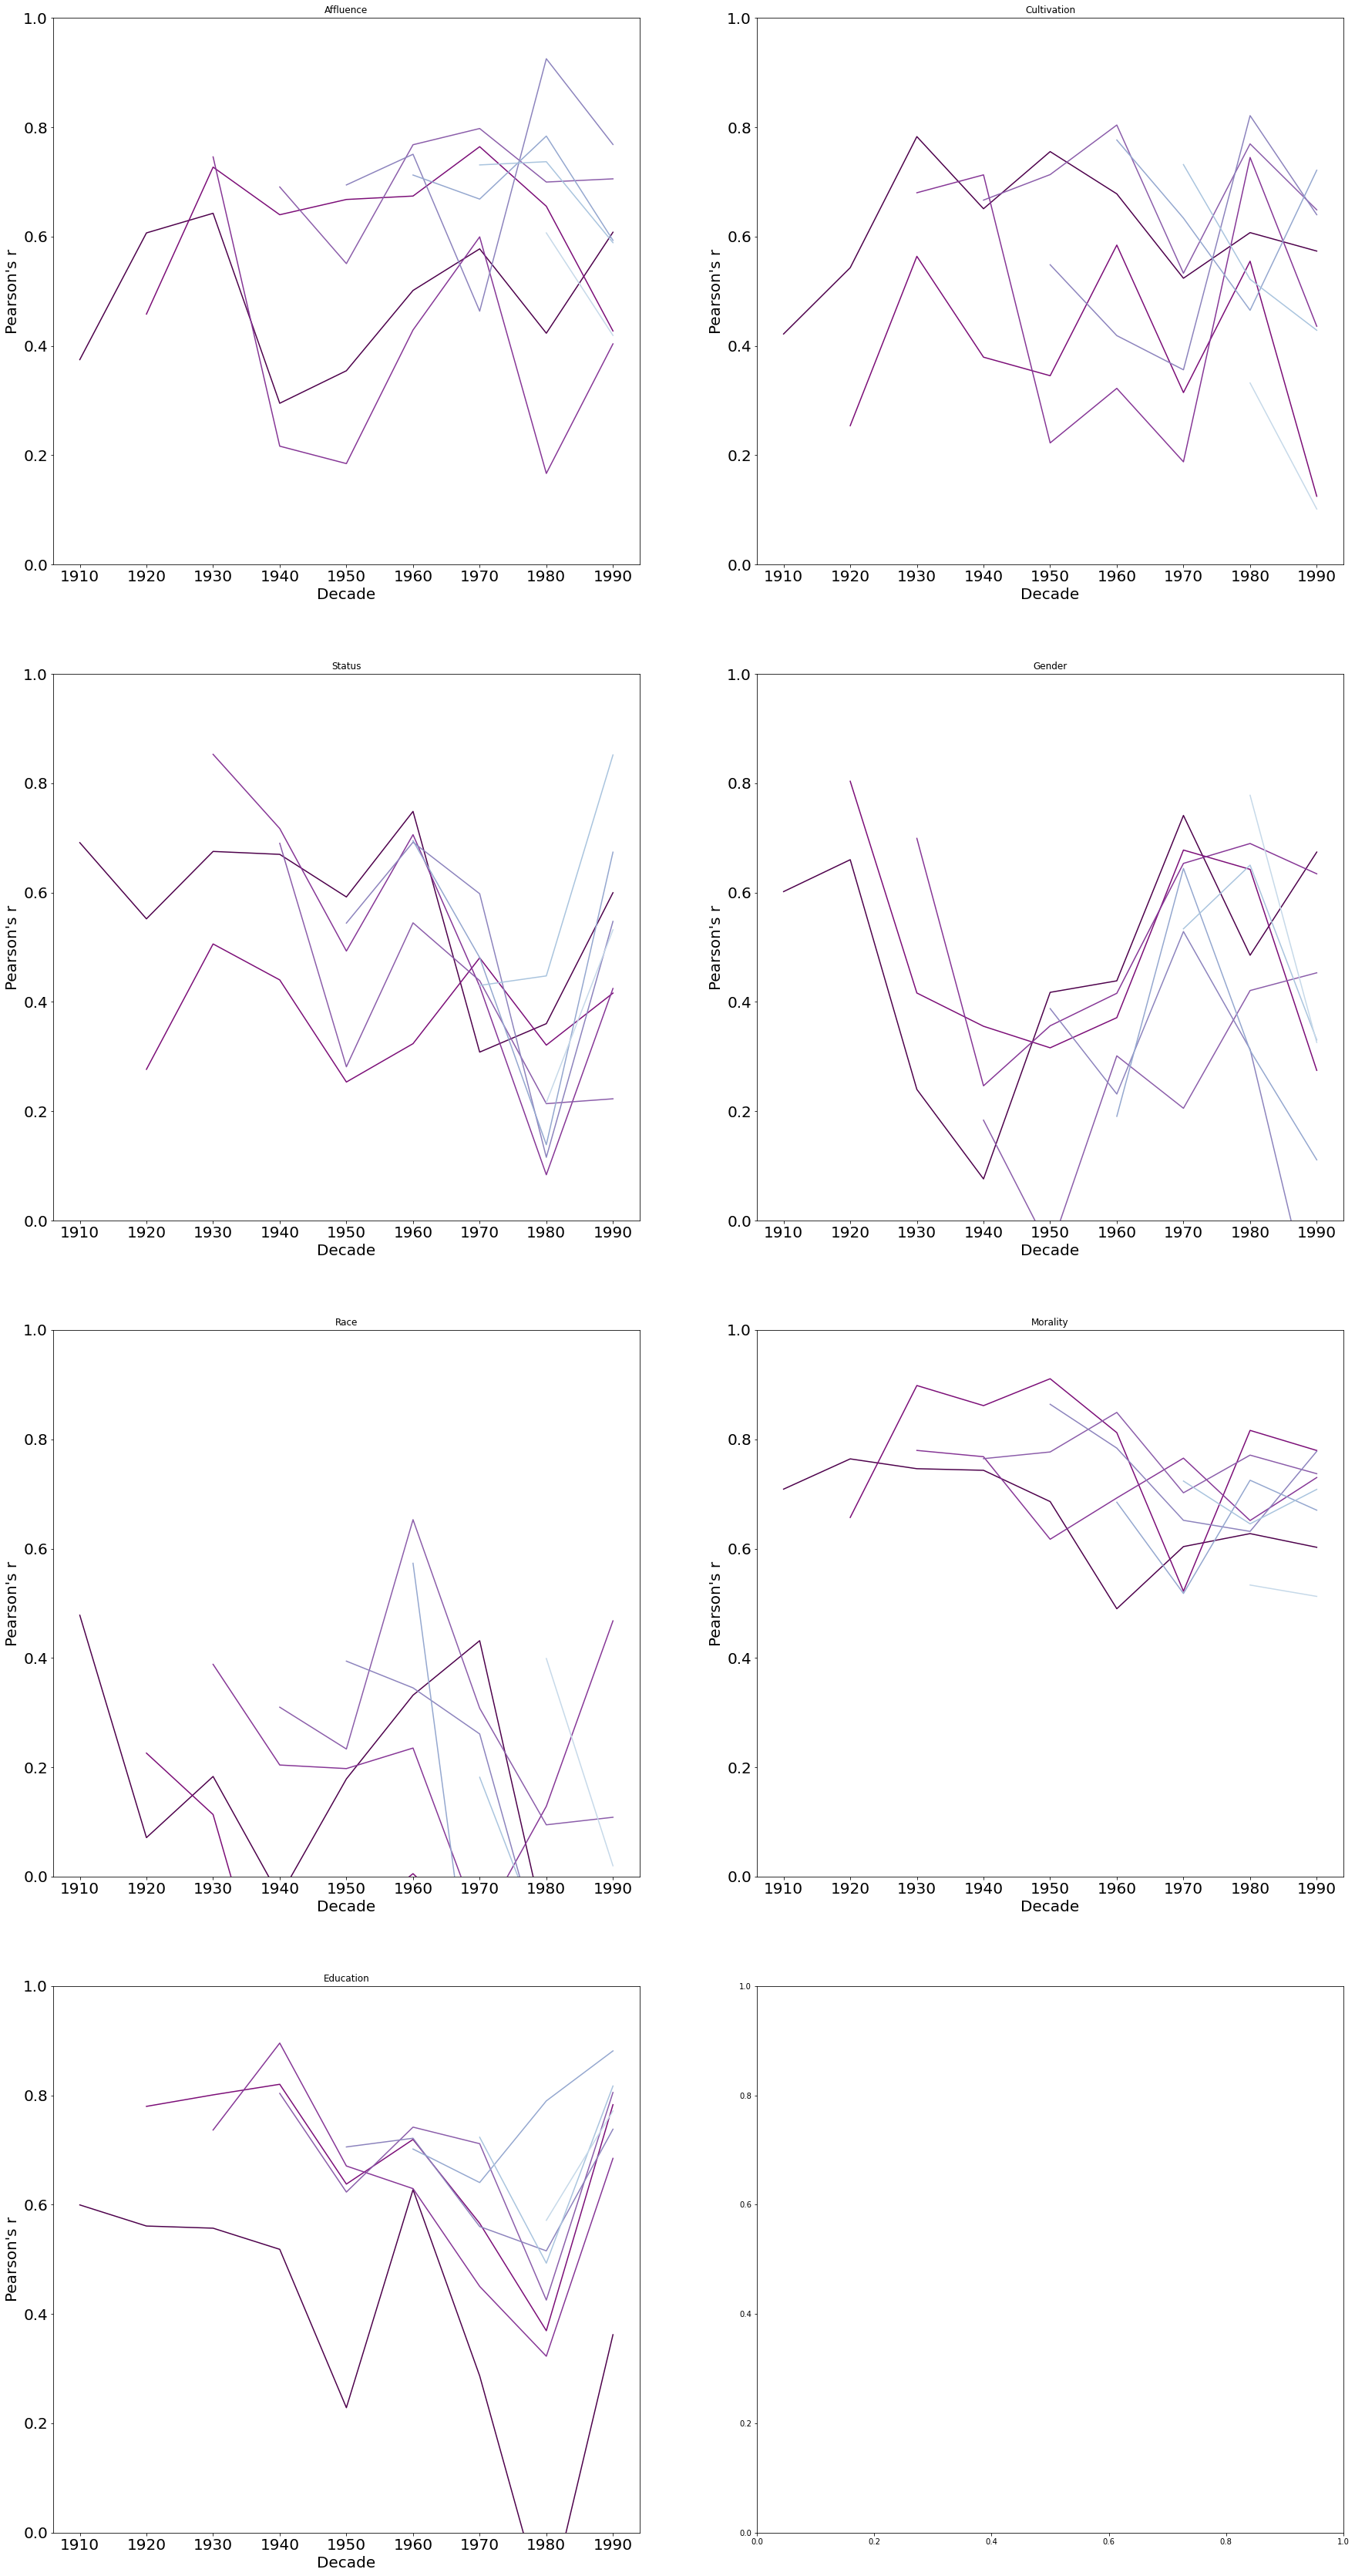

In [6]:
vec_tools.get_projection_corrs(histwords_iter, domain_dic["sports"])
vec_tools.plot_projection_corrs(histwords_iter, n=8, k=2, save = "sports")

# General

In [18]:
from matplotlib import cm
def chart_project_dict(proj_1, p1_label, proj_2, p2_label, title, domain_dic, wv, dim_1_span, dim_2_span, undesire=[], no = [],show=True):
    inds = []
    projs = {cat: {"dim_1": {}, "dim_2": {}} for cat in domain_dic.keys()}
    means = {cat: {"dim_1": [], "dim_2": []} for cat in domain_dic.keys()}
  #  means["General"] = {"dim_1": [0], "dim_2": [0]}
   # projs["General"] = {"dim_1": [0], "dim_2": [0]}

    for cat, lst in domain_dic.items():
        for word in lst:
            if word.lower() in no:
                continue
            try:
                ind = wv.get_index(word.lower())
                inds.append(ind)
                val1, val2 = proj_1[ind], proj_2[ind]
                means[cat]["dim_1"].append(val1)
                means[cat]["dim_2"].append(val2)
                #projs = (val1, val2)
                projs[cat]["dim_1"][word] = val1
                projs[cat]["dim_2"][word] = val2
                
            except Exception as e:
                continue
   
    for cat in means.keys():
        means[cat]["dim_1"] = statistics.mean(means[cat]["dim_1"])
        means[cat]["dim_2"] = statistics.mean(means[cat]["dim_2"])
    #means["General"]["dim_1"] = statistics.mean([means[cat]["dim_1"] for cat in means.keys() if cat != "General"])
    #means["General"]["dim_2"] = statistics.mean([means[cat]["dim_2"] for cat in means.keys() if cat != "General"])

    #return projs
    plt.style.use("ggplot")
    plt.rcParams["font.family"] = "Times New Roman"

    colours = list(cm.Dark2(np.linspace(0, 1, 7))) + ["skyblue", "rosybrown", "khaki", "black"]
    #colours = {i: colour["color"] for i, colour in enumerate(plt.rcParams['axes.prop_cycle'])}
    #colours = ["red", "yellow", "blue", "orange", "green", "purple", "teal", "#CD9575", "#665D1E", "#915C83", "#841B2D", "#C46210", "#9966CC", "#0D98BA", "#4D1A7F", "#003153"]
    fig, ax = plt.subplots(figsize=((6.062958350629584, 3.747114333064086)))
    ax.set_xlabel(p1_label, fontsize=7)
    ax.set_ylabel(p2_label, fontsize=7)
    ax.set_xlim(left=dim_1_span[0], right=dim_1_span[1])
    ax.set_ylim(bottom=dim_2_span[0], top=dim_2_span[1])
    x = ax.axvline(x=0, c="silver", clip_on=False, linewidth=1)#, label="x=0")
    y = ax.axhline(y=0, c="silver", clip_on=False, linewidth=1)#, label="y=0")
    x.set_clip_on(False)
    y.set_clip_on(False)
    ax.tick_params(axis='x',labelsize=6, zorder=1)
    ax.tick_params(axis='y',labelsize=6, zorder=1)
    #ax.axvline(x=means["General"]["dim_1"], c="silver")#, label="x=0")
    #ax.axhline(y=means["General"]["dim_2"], c="silver")#, label="y=0")
    ax
    i = 0
    for cat, dic in projs.items():
        ax.scatter(means[cat]["dim_1"], means[cat]["dim_2"], marker = "o", s=50, color = colours[i])
        ax.annotate(text= "Mean: "+cat, xy=(means[cat]["dim_1"], means[cat]["dim_2"]), zorder=2, size = 5,
                    xytext= (3,-8), textcoords="offset points", style="italic" )
        df = pd.DataFrame(dic)
        ax.scatter(df.loc[:, "dim_1"], df.loc[:, "dim_2"], clip_on=True, label=cat, s=25, marker="o", zorder=2, alpha= 0.8, color=colours[i])
        for idx, row in df.iterrows():
            if row.name.lower() in undesire:
                continue
            ax.annotate(text=row.name.capitalize(), xy=(row["dim_1"], row["dim_2"]), xytext= (3,-5), size=5, textcoords="offset points" )
        i += 1
    ax.legend(prop={'size': 5}, loc="lower right")
    #plt.legend(loc="lower left", fontsize=7)
    plt.savefig(title, format="png")
    if show == False:
        plt.clf()

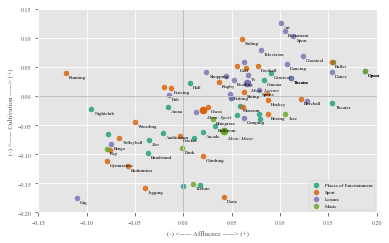

In [19]:
wv1990 = histwords_iter.wvs["1990"]
undesires = ["hurdles", "hunting", "bowling", "exercise", "magazine", "gallery", "tennis", "stadium", "amphitheatre", "mall","playground", "circus", "spa", "billiards", "gardening", "marquee", "concert", "festival"]
to_plt = {dom:lst for dom, lst in domain_dic["all_cult"].items() if dom != "Clothing"}
chart_project_dict(proj_1=histwords_iter.projs["1990"]["affluence"], 
                                    p1_label="(-) <----- Affluence -----> (+)", 
                                    proj_2=histwords_iter.projs["1990"]["cultivation"], 
                                    p2_label="(-) <----- Cultivation -----> (+)",
                                    title="Cultural domain", 
                                    undesire=undesires,
                                    domain_dic=to_plt, 
                                    wv=wv1990, 
                                    show=True,
                                    dim_1_span=(-.15,.2),
                                    dim_2_span= (-.2,.15)
                            )
plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/lifestyles.jpg", dpi=400, bbox_inches = "tight")

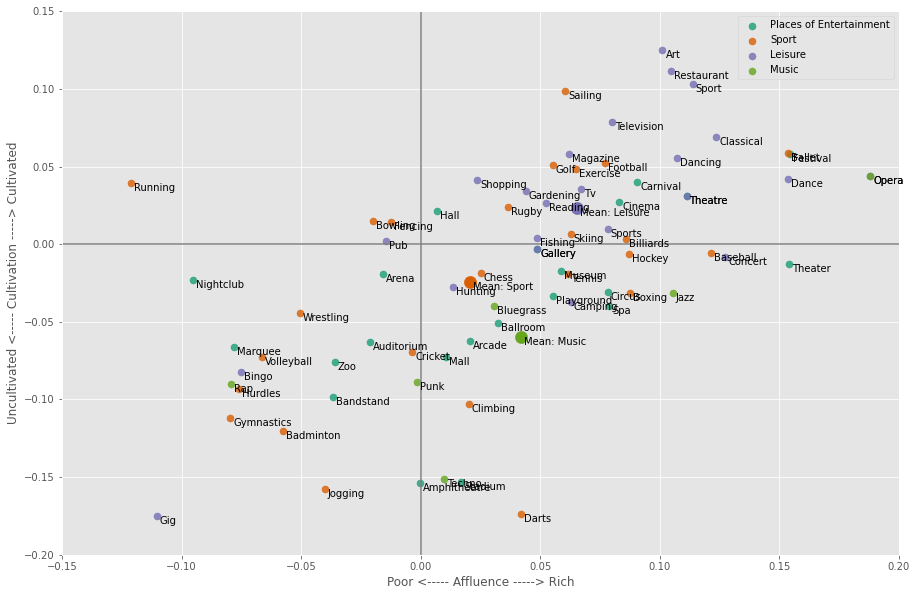

In [10]:
colours = cm.tab20(np.linspace(0, 1, 4))
wv1990 = histwords_iter.wvs["1990"]
to_plt = {dom:lst for dom, lst in domain_dic["all_cult"].items() if dom != "Clothing"}
vec_tools.chart_project_dict(proj_1=histwords_iter.projs["1990"]["affluence"], 
                                    p1_label="Poor <----- Affluence -----> Rich", 
                                    proj_2=histwords_iter.projs["1990"]["cultivation"], 
                                    p2_label="Uncultivated <----- Cultivation -----> Cultivated",
                                    title="Cultural domain", 
                                    domain_dic=to_plt, 
                                    wv=wv1990, 
                                    show=True,
                                    dim_1_span=(-.15,.2),
                                    dim_2_span= (-.2,.15)
                            )

In [8]:

vec_tools.corr_project_dict(proj_1=histwords_iter.projs["1990"]["affluence"], 
                                    proj_2=histwords_iter.projs["1990"]["status"], 
                                    title="Cultural domain", 
                                    domain_dic=to_plt, wv = wv1990)

Places of Entertainment
(0.38252300916616233, 0.07891924481098611)
Music
(0.8635277945636337, 0.026666119877219677)
Sport
(0.5863051998839129, 0.0020691736039426217)
Leisure
(0.4202106435125018, 0.045890757350495276)
Overall
 (0.4888725920432597, 7.43592781187922e-06)


In [ ]:
from scipy.stats import pearsonr
for i in range(len(histwords_iter.projs["1990"]["affluence"])):
               print(histwords_iter.projs["1990"]["affluence"][i],histwords_iter.projs["1990"]["cultivation"][i])
#pearsonr(histwords_iter.projs["1990"]["affluence"],histwords_iter.projs["1990"]["cultivation"])

In [ ]:
# CONVERGENCE
import numpy as np
self = histwords_iter
df = {dom: {} for dom in domain_dic["all_cult"].keys()}
for dom, wl in domain_dic["all_cult"].items():
    for dim in ["cultivation", "affluence"]:
        #print("Domain:", dom, "Dim:", dim)
        for dec, wv in self.wvs.items():
            vals = []
            for word in wl: 
                try:
                    ind = wv.get_index(word.lower())
                    proj = self.projs[dec][dim][ind]
                    if not proj == proj:
                        continue
                    vals.append(proj)
                except:
                    pass
            var = np.var(vals)
            df[dom][dec] = var
            #print(dec, " variance:", var)
df = pd.DataFrame(df)
df.plot.line()

# Sports

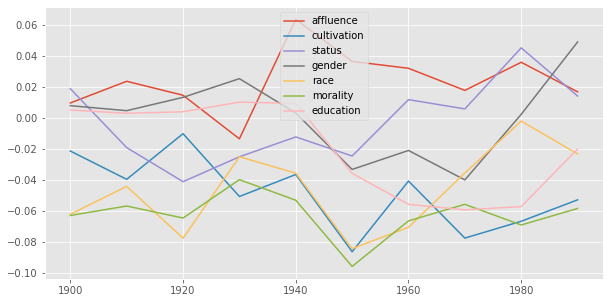

In [82]:
wlist = domain_dic["sports"]
vec_tools.aggregate_word_line_graph(histwords_iter, wlist)

# Boxing

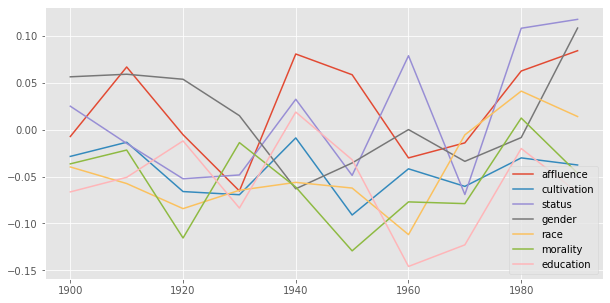

In [98]:
wlist = ["boxing"]
vec_tools.aggregate_word_line_graph(histwords_iter, wlist)

In [93]:
#check validity of aggregate
wv1990 = histwords_iter.wvs["1990"]
wv1990.most_similar(positive="boxing", topn=30)

[('wuz', 0.44008928537368774),
 ('dont', 0.40310654044151306),
 ('dysentery', 0.39914435148239136),
 ('nothin', 0.3895930051803589),
 ('thinkin', 0.3791057765483856),
 ('nuit', 0.37797099351882935),
 ('flu', 0.3743126392364502),
 ('peu', 0.37037599086761475),
 ('whooping', 0.35602903366088867),
 ('chacun', 0.3483133912086487),
 ('sorry', 0.34048736095428467),
 ('remarques', 0.3395974934101105),
 ('souffle', 0.3392992317676544),
 ('bonne', 0.33705270290374756),
 ('bouts', 0.33550792932510376),
 ('talkin', 0.33532601594924927),
 ('venir', 0.3306538462638855),
 ('tard', 0.330466628074646),
 ('hey', 0.3296085596084595),
 ('tonsillitis', 0.32949692010879517),
 ('traitement', 0.3283836841583252),
 ('pang', 0.32453209161758423),
 ('loca', 0.3232324719429016),
 ('nuthin', 0.3218548893928528),
 ('shit', 0.3212308883666992),
 ('hurts', 0.3198082149028778),
 ('overdose', 0.3196098506450653),
 ('horrible', 0.3194020986557007),
 ('quelques', 0.3184516727924347),
 ('salpetriere', 0.318217009305954)]

In [94]:
wv1900 = histwords_iter.wvs["1900"]
wv1900.most_similar(positive="boxing", topn=30)

[('dunno', 0.5487698316574097),
 ('gwine', 0.421303927898407),
 ('gars', 0.41971132159233093),
 ('hev', 0.4183679223060608),
 ('dat', 0.41733404994010925),
 ('sah', 0.40238749980926514),
 ('tillet', 0.4006998836994171),
 ('massa', 0.3960416316986084),
 ('hulot', 0.38823211193084717),
 ('jes', 0.3828318417072296),
 ('git', 0.380813330411911),
 ('suh', 0.38050949573516846),
 ('wa', 0.373091459274292),
 ('makin', 0.3712640106678009),
 ('gettin', 0.3689257800579071),
 ('talkin', 0.3665141761302948),
 ('maun', 0.36459025740623474),
 ('propos', 0.3644642233848572),
 ('thet', 0.3636413514614105),
 ('waitin', 0.3583000898361206),
 ('ole', 0.3578721284866333),
 ('toujours', 0.35418641567230225),
 ('orsay', 0.35409048199653625),
 ('semper', 0.3531338572502136),
 ('artagnan', 0.3525187373161316),
 ('sud', 0.34846019744873047),
 ('quand', 0.34840697050094604),
 ('haut', 0.3479737639427185),
 ('noir', 0.3475956320762634),
 ('gar', 0.3467622995376587)]

# Impressionism

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


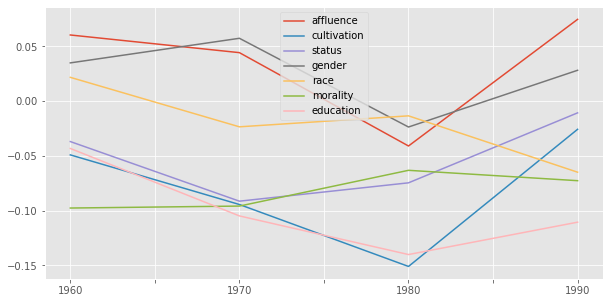

In [10]:
wlist = ["impressionism"]
vec_tools.aggregate_word_line_graph(histwords_iter, wlist)

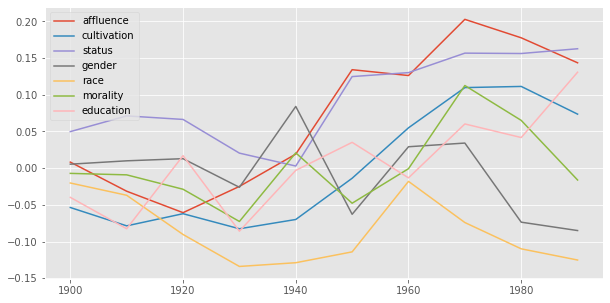

In [11]:
wlist = ["garde"]
vec_tools.aggregate_word_line_graph(histwords_iter, wlist)

In [12]:
wv1990 = histwords_iter.wvs["1960"]
wv1990.most_similar(positive="impressionist", topn=30)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


[('carrington', 0.43689557909965515),
 ('surrealist', 0.38889747858047485),
 ('graphics', 0.387549489736557),
 ('stearns', 0.3661600947380066),
 ('ecstasies', 0.36566293239593506),
 ('grimes', 0.3632931709289551),
 ('humphreys', 0.3618040978908539),
 ('freiburg', 0.35449957847595215),
 ('kaye', 0.35449087619781494),
 ('727', 0.3541561961174011),
 ('leavis', 0.35392072796821594),
 ('memoriam', 0.3529556095600128),
 ('eyewitnesses', 0.3525850176811218),
 ('cline', 0.34978795051574707),
 ('vermeer', 0.34504714608192444),
 ('painters', 0.339591920375824),
 ('743', 0.3371177911758423),
 ('ackerman', 0.3358416259288788),
 ('biding', 0.3352700471878052),
 ('totemism', 0.33521950244903564),
 ('1646', 0.3349471688270569),
 ('latourette', 0.3347785770893097),
 ('kemble', 0.33307570219039917),
 ('1724', 0.3319905996322632),
 ('reynal', 0.3311215043067932),
 ('paxton', 0.32880282402038574),
 ('orton', 0.3283006548881531),
 ('cataloguing', 0.32749322056770325),
 ('kiangsu', 0.32708775997161865),
 (

# Polar graph

In [13]:
vec_tools.polar_graph(histwords_iter, wlist)

# PCA

In [25]:
wv1990 = histwords_iter.wvs["1990"]
dic = {"Sports": domain_dic["sports"]}
topns = [len(val) for key, val in dic.items()] #amount in each list
sims = []
centroids = []
for key, val in dic.items():
    sims.extend(val)
    centroids.append(key)
#vec_tools.display_pca_scatterplot_3D(model=wv1990, similars=False, user_input=centroids, words=sims, topns=topns)

In [106]:
vec_tools.display_pca_scatterplot_2D(model=wv1990, similars=False, user_input=centroids, words=sims, topns=topns)

In [16]:
#"goc_genres", "art_movs", "hobbies", "genres", "emerging_traditional_genres", "housing"
vec_tools.chart_project_dict(proj_1=histwords_iter.projs["1990"]["affluence"], 
                                    p1_label="affluence", 
                                    proj_2=histwords_iter.projs["1990"]["cultivation"], 
                                    p2_label="cultivation",
                                    title="Professions", 
                                    domain_dic=domain_dic["Iso_occupations"], 
                                    wv=wv, 
                                    show=True,
                                    dim_1_span=(-.2,.2),
                                    dim_2_span= (-.2,.2)
                            )

NameError: name 'wv' is not defined

In [ ]:
vec_tools.chart_project(proj_1=histwords_iter.projs["1990"]["affluence"], 
                                    p1_label="affluence", 
                                    proj_2=histwords_iter.projs["1990"]["cultivation"], 
                                    p2_label="cultivation",
                                    title="Professions", 
                                    word_list=professions, 
                                    wv=wv, 
                                    show=True,
                                    dim_1_span=(-.2,.2),
                                    dim_2_span= (-.2,.2)
                            )

# 1900-1990 comparison

In [ ]:
!pip install -U kaleido

In [ ]:
#line graph
word_list = domain_dic["occupations1950"][:7]
word_projs = {word: {} for word in word_list}
year_1, year_2 = ["1900", "1990"]
dim = "affluence"

for dec in [year_1, year_2]:
    for word in word_list:
        ind = self.wvs[dec].get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[word][dec] = proj
df = pd.DataFrame(word_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
df.plot.line()
#df.unstack()

In [ ]:
#polar graph *NEEDS GRADIATION of colour
import plotly.express as px
px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)